## Ripple Detection

This notebook is split into two parts:

<b> Part I - Speed calculation </b>

    (A) Open raw position data and timestamps;
    (B) Convert position from pixels to cm;
    (C) Combine xy and timestamps into a single dataframe;
    (D) Classify position data according to maze segments;
    (E) Calculate speed based on the maze segments the rat is in;
    (F) Collect the ephys timestamps;
    (G) Merge the ephys timestamps with timestamped position data and interpolate the speed data points.
    (H) Get ephys /LFP data and filter it.
    

<b> Part II - Ripple Detection </b>

 Explained below. Using ripple_detection package from the Eden-Kramer Lab, based on Kay et al. 2016.

#### Load required packages

In [125]:
import numpy as np
import re
import matplotlib.pyplot as plt
from ripple_detection import *
from swr_detector_utils import *
from position_utils import classify_maze_segments
%matplotlib inline

#### Define variables
Every time a dataset is processed, these variables should be checked.

In [215]:
path ='E:/EPHYS/data/NAPOLEAO_DNMP22_18_trials_20180504094832'
session_code=re.search(r'trials_([0-9]+)', path).group(1)
rat_code=re.search(r'([A-Z]+)_DNMP', path).group(1)[0:3]
tts=[16,17]
rate=3000 # For Homero the rate is 2K

## I. Data preparation

##### Get position data (raw) and position timestamps

In [216]:
# Open the raw position data
x = pd.read_csv(
    os.path.join(path, '{}_b_{}.csv'.format(session_code, 'xcoord')),
    header=None, names=['x'], delim_whitespace=True
)
y = pd.read_csv(
    os.path.join(path, '{}_b_{}.csv'.format(session_code, 'ycoord')),
    header=None, names=['y'], delim_whitespace=True
)
time = pd.read_csv(
    os.path.join(path, '{}_b_{}.csv'.format(session_code, 'tstamp_image')),
    header=None, names=['timestamp'], delim_whitespace=True
)

#### Convert position from px to cm and timestamps. Combine all

In [217]:
# Concatenate the position data
position = pd.concat([x, y], axis=1)
# Converts xy from pixels to cm.
position = (position.astype(float)*10)/50
# Interpolate NaN and zeros (loss of position data) in position dataframe
position = (position.replace(0, np.nan)
                    .interpolate(method='linear', limit=5)
                    .fillna(0))

# Convert timestamps to seconds and reference it to the first timestamp (1st timestamp = 0)
first_timestamp = time.iloc[0]
timestamps_conv = (time - first_timestamp) * 1e-7
# Concatenate timestamps and position into a single 3 column, 2 x levels index DataFrame.
timestamped_position = pd.concat([timestamps_conv, position], axis=1)

#### Classify position by maze segments

The position data is classified according to the respective maze segment. 
When the rat is in the central arm and reward arms, the speed is calculated on the x axis only (only uses delta x);
In the pre-corner arms we will only use delta y.
Finally, at the start region, corners and choice point, the euclidean velocity will be calcutated (using both delta x and delta y).

In [218]:
# classify according to maze segments
timestamped_position = classify_maze_segments(path, timestamped_position, session_code)

In [219]:
# Napoleão has an extra maze segment (I used the box for the ITI)
if rat_code == 'NAP': 
    box_mask = (timestamped_position.x.between(50,130)) & (timestamped_position.y.between(0,90))
    timestamped_position.loc[box_mask, 'maze_segment']='Box'

In [220]:
sns.set(style='white', context='talk')
plt.Figure(figsize=(10,8))
# Plot position data
g=sns.scatterplot(
    data = timestamped_position,
    x='x', 
    y='y', 
    hue='maze_segment', 
    s=3, 
    alpha=1
)
plt.legend(loc='upper right', bbox_to_anchor=(1.6,1))
sns.despine()
plt.show()

#### Calculate speed according to maze segments

In [221]:
# Calculate numerators and denominators
timestamped_position['y_diff']=(timestamped_position['y'].diff()).fillna(0)
timestamped_position['x_diff']=(timestamped_position['x'].diff()).fillna(0)
timestamped_position['delta_d'] = np.sqrt(timestamped_position['x_diff']**2 + timestamped_position['y_diff']**2)
timestamped_position['delta_t']=(timestamped_position['timestamp'].diff()).fillna(0)

# Calculate speed
timestamped_position.loc[
    timestamped_position['maze_segment'].isin(['Start arm', 'Corners', 'Choice point', 'Box']), 
    'vel']=timestamped_position.delta_d / timestamped_position.delta_t

timestamped_position.loc[
    timestamped_position['maze_segment']=='Central/Rw arms', 
    'vel']=timestamped_position.x_diff / timestamped_position.delta_t

timestamped_position.loc[
    timestamped_position['maze_segment'].isin(['Pre-corners']), 
    'vel']=timestamped_position.y_diff / timestamped_position.delta_t

In [222]:
timestamped_position.loc[abs(timestamped_position.vel)>100, 'vel']=np.nan
print('\n Number of points to interpolate: {}'.format(timestamped_position.vel.isna().sum()))
# Interpolate NaNs using linear interpolation (limit=1)
timestamped_position.vel.interpolate(limit=10, inplace=True)
# Take speed's absolute value
timestamped_position.vel = abs(timestamped_position.vel)


 Number of points to interpolate: 2950


#### Get ephys timestamps

In [223]:
timestamp_path = os.path.join(path, 'Ephys_timestamps')
timestamp_files = get_file_list(timestamp_path, "*.csv")
timestamp_chunks = []

for t in timestamp_files:
    
    # Open timestamp file
    tfile_path = os.path.join(timestamp_path, t)
    chunk = pd.read_csv(tfile_path, index_col=0).rename(columns={'0':'timestamp'}).reset_index(
            drop=True)
    timestamp_chunks.append(chunk)

    # Concatenate the ephys timestamps into a single dataframe
    ephys_timestamps=pd.concat(timestamp_chunks, axis=0)

#### Interpolate speed, x and y datapoints using timestamp chunks

In [224]:
# Combine position data with ephys timestamps
timestamps_merged=pd.concat([
    ephys_timestamps, timestamped_position[['timestamp', 'vel', 'x', 'y']]]
)
# Sort values by timestamp
timestamps_sorted=timestamps_merged.sort_values(by=['timestamp']).reset_index(drop=True)   

# Keep first timestamps if we have duplicated timestamps
timestamped_xy = timestamps_sorted.groupby(['timestamp']).first().reset_index()

# Interpolate missing values
timestamped_xy[['vel_interp', 'x_interp', 'y_interp']] = timestamped_xy[
    ['vel', 'x', 'y']].interpolate(method='linear')  

In [225]:
print(len(timestamps_sorted), len(timestamped_xy), len(ephys_timestamps))

7234645 7234611 7199567


#### Keep only speed and xy values relating to ephys timestamps
The camera sometimes captures different timestamps from the ones captured by the ephys system. When both dataframes are combined we get more timestamps than just the ephys ones. We keep them all when calculating the interpolated the velocity but once the calculation is complete, we only keep the speed and xy position data associated with the ephys timestamps

In [226]:
timestamps_list = ephys_timestamps['timestamp'].tolist()
timestamped_xy_clean=timestamped_xy[timestamped_xy.timestamp.isin(timestamps_list)]

In [227]:
len(timestamped_xy_clean)

7199567

<IPython.core.display.Javascript object>


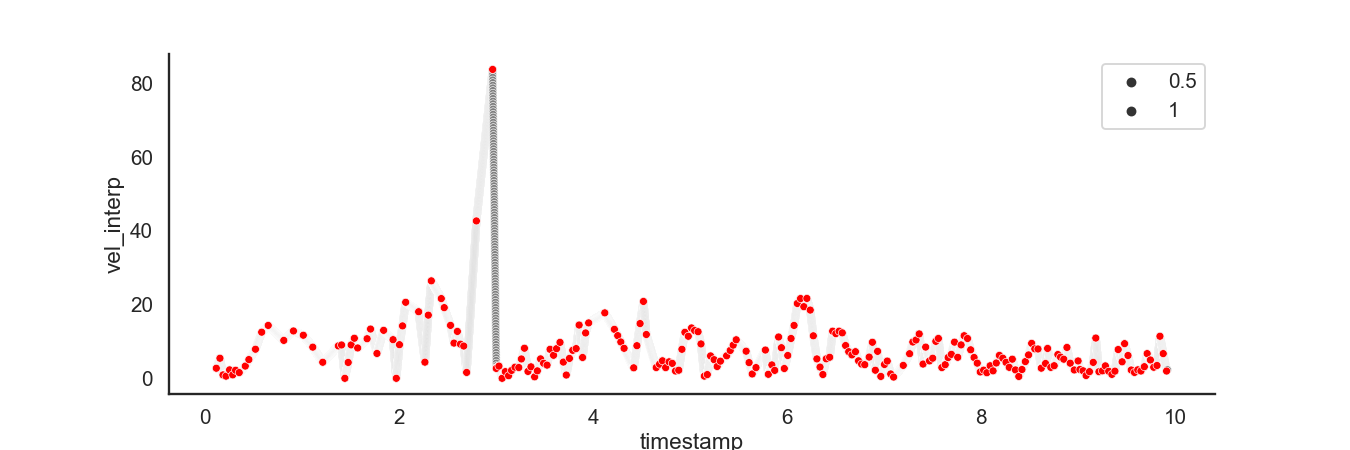

In [228]:
# Plot velocity
plt.figure(figsize=(15,5))
sns.scatterplot(data=timestamped_xy.head(30000),x='timestamp', y='vel_interp', size=.5, color='gray')
sns.scatterplot(data=timestamped_xy.head(30000),x='timestamp', y='vel', size=1, color='red')
sns.despine()

In [229]:
# Select columns of interest
time = ephys_timestamps.timestamp.to_numpy()
speed = timestamped_xy_clean.vel_interp.to_numpy()
x = timestamped_xy_clean.x_interp.to_numpy()
y = timestamped_xy_clean.y_interp.to_numpy()

#### Get LFP
The LFP is sub-sampled to 1/10 of the datapoints. It is stored in chunks of 90K samples, except the first one, in which the ephys data acquired before the camera started acquiring image was removed.

In [230]:
tt_lfps=dict()

for tt in tqdm(tts): 
    # Get file list
    tt_path=os.path.join(path, 'TT{}'.format(tt))
    files = get_file_list(tt_path, "*.csv")   
    
    tt_lfp=list()     
    for f in files:
        
        # Read each ephys raw data file
        file_path = os.path.join(tt_path, f)
        chunk = pd.read_csv(file_path, index_col=0)
        # Append chunk dataframe from each file to list
        tt_lfp.append(chunk)
        
    # Concatenate and store in a dictionary   
    tt_lfps[tt]=pd.concat(tt_lfp)

100%|████████████████████████████████████████████| 2/2 [00:42<00:00, 21.49s/it]


#### Remove dead channels
Magalhães: TT28 (Channel 16)
Homero: TT16 (Channel 105, 107) + TT18 (Channel 113)

In [231]:
# Remove dead channels
if rat_code=='MAG' and 28 in tt_lfps.keys():
    tt_lfps[28]=tt_lfps[28].drop(['16'], axis=1)
    
elif rat_code=='HOM' and 16 in tt_lfps.keys():
    tt_lfps[16]=tt_lfps[16].drop(['105', '107'], axis=1)
    
elif rat_code=='HOM' and 18 in tt_lfps.keys():
    tt_lfps[18]=tt_lfps[18].drop(['113'], axis=1)

In [232]:
# Stack ephys dataframes as arrays
lfps=np.hstack(([tt_lfps[tt].to_numpy() for tt in sorted(tt_lfps)]))
lfps.shape

(7199567, 8)

#### Clear variables no longer needed from environment (to clear RAM)

In [233]:
del tt_lfps, timestamped_xy_clean, timestamped_position, ephys_timestamps, chunk, timestamped_xy, timestamps_merged, timestamps_sorted

#### Filter LFP
The kernel is 150-250 Hz bandpass with 40 db roll off and 10 Hz sidebands. Sampling frequency is 1500 Hz. The function is from package ripple detection too.

In [234]:
filtered_lfps = filter_ripple_band(lfps)

## II. Ripple detection
<br>
<b>Data transformations</b>: squares the data in all channels. Sums the data into a single column and smooths it using a gaussian kernel. Afterward it square-rots the smoothed sum. 

<b>Event detection</b>: When the signal exceeds 2xsd of the recording epoch mean for at least 15 ms. The segments above threshold - if they remain above the threshold
    for 15ms - have their start time/end time when crossing the mean. 

<b>Exclusion criteria </b>: If the rat's velocity is above a given threshold (4 cm/s). 

<br>

### Parameters:
<b>time</b>: array_like, shape (n_time,)

<b>filtered_lfps</b>:array_like, shape (n_time, n_signals). Bandpass filtered time series of electric potentials in the ripple band        
<b>speed</b> : array_like, shape (n_time,). Running speed of animal

<b>sampling_frequency</b>: float Number of samples per second.

<br>

<b>Optional</b>: 

speed_threshold=4.0 

minimum_duration=0.015 

zscore_threshold=2.0 

smoothing_sigma=0.004

close_ripple_threshold=0.0



In [235]:
ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, rate)

In [236]:
# Remove ripples with duration > 700 ms
ripple_times['duration']=ripple_times['end_time']-ripple_times['start_time']

In [237]:
ripple_times = ripple_times[ripple_times.duration<.5]

In [238]:
len(ripple_times)

99

#### Plot ripples

In [239]:
raw=lfps[:, 4]
filtered=filtered_lfps[:,4]

<IPython.core.display.Javascript object>


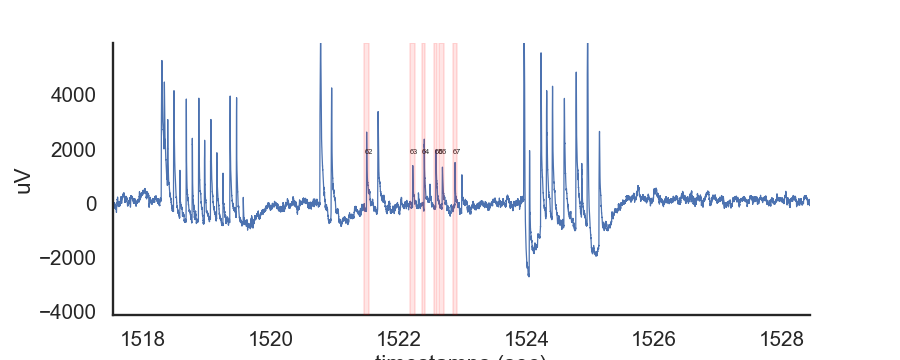

In [240]:
%matplotlib notebook
plt.rcParams['animation.html']='jshtml'
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time, raw, linewidth=1)
#ax.plot(time, filtered+750, linewidth=1)
#ax.plot(time, original+2000, linewidth=1)
#ax.plot(time, [2004]*len(time), linestyle='dotted')

for ripple in ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.1, color='red', zorder=1000)
    ax.text(ripple.start_time, 1800, ripple.Index, {'size':6})

plt.xlabel('timestamps (sec)')
plt.ylabel('uV')
sns.despine()

#### Save
Save ripples, interpolated xy, speed and timestamps 

In [ ]:
filename='{}_{}_ripples.csv'.format(rat_code, session_code)
_path=os.path.join(path, filename)
ripple_times.to_csv(_path, index=False)